In [1]:
#!/usr/bin/env python

'''
example to show optical flow

USAGE: opt_flow.py [<video_source>]

Keys:
 1 - toggle HSV flow visualization
 2 - toggle glitch

Keys:
    ESC    - exit
'''

# Python 2/3 compatibility
from __future__ import print_function

import numpy as np
import cv2


def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis


def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr


def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

if __name__ == '__main__':
    import sys
    print(__doc__)
    try:
        fn = sys.argv[1]
    except IndexError:
        fn = 0

    cam = cv2.VideoCapture(fn)
    cam.open(0)
    ret, prev = cam.read()
    
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    show_hsv = False
    show_glitch = False
    cur_glitch = prev.copy()

    while True:
        ret, img = cam.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        prevgray = gray

        cv2.imshow('flow', draw_flow(gray, flow))
        if show_hsv:
            cv2.imshow('flow HSV', draw_hsv(flow))
        if show_glitch:
            cur_glitch = warp_flow(cur_glitch, flow)
            cv2.imshow('glitch', cur_glitch)

        ch = cv2.waitKey(5)
        if ch == 27:
            break
        if ch == ord('1'):
            show_hsv = not show_hsv
            print('HSV flow visualization is', ['off', 'on'][show_hsv])
        if ch == ord('2'):
            show_glitch = not show_glitch
            if show_glitch:
                cur_glitch = img.copy()
            print('glitch is', ['off', 'on'][show_glitch])
    cam.release()
    cv2.destroyAllWindows()



example to show optical flow

USAGE: opt_flow.py [<video_source>]

Keys:
 1 - toggle HSV flow visualization
 2 - toggle glitch

Keys:
    ESC    - exit



In [6]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)


# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

In [3]:
import cv2
import numpy as np
cap = cv2.VideoCapture(0)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()

In [1]:
import cv2
def diffImg(t0, t1, t2):
    d1 = cv2.absdiff(t2, t1)

    d2 = cv2.absdiff(t1, t0)
    return cv2.bitwise_and(d1, d2)

cam = cv2.VideoCapture(0)
winName = "Movement Indicator"
cv2.namedWindow(winName)
# Read three images first:
t_minus = cv2.cvtColor(cam.read()[1], cv2.COLOR_RGB2GRAY)
t = cv2.cvtColor(cam.read()[1], cv2.COLOR_RGB2GRAY)
t_plus = cv2.cvtColor(cam.read()[1], cv2.COLOR_RGB2GRAY)
while True:
    cv2.imshow( winName, diffImg(t_minus, t, t_plus) 
    # Read next image
    t_minus = t
    t = t_plus
    t_plus = cv2.cvtColor(cam.read()[1], cv2.COLOR_RGB2GRAY)
    key = cv2.waitKey(10)
    if key == 27:
        cv2.destroyWindow(winName)
        break


In [5]:
import numpy as np
import scipy.signal as si
from PIL import Image

def gauss_kern():
    h1 = 15
    h2 = 15
    x, y = np.mgrid[0:h2, 0:h1]
    x = x-h2/2
    y = y-h1/2
    sigma = 1.5
    g = np.exp( -( x**2 + y**2 ) / (2*sigma**2) );
    return g / g.sum()

def deriv(im1, im2):
    g = gauss_kern()
    Img_smooth = si.convolve(im1,g,mode='same')
    fx,fy=np.gradient(Img_smooth)  
    ft = si.convolve2d(im1, 0.25 * np.ones((2,2))) + \
       si.convolve2d(im2, -0.25 * np.ones((2,2)))
                 
    fx = fx[0:fx.shape[0]-1, 0:fx.shape[1]-1]  
    fy = fy[0:fy.shape[0]-1, 0:fy.shape[1]-1];
    ft = ft[0:ft.shape[0]-1, 0:ft.shape[1]-1];
    return fx, fy, ft

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as si
from PIL import Image

import numpy.linalg as lin

def lk(im1, im2, i, j, window_size) :
    fx, fy, ft = deriv(im1, im2)
    halfWindow = np.floor(window_size/2)
    curFx = fx[int(i-halfWindow-1):int(i+halfWindow),
              int(j-halfWindow-1):int(j+halfWindow)]
    curFy = fy[int(i-halfWindow-1):int(i+halfWindow),
              int(j-halfWindow-1):int(j+halfWindow)]
    curFt = ft[int(i-halfWindow-1):int(i+halfWindow),
              int(j-halfWindow-1):int(j+halfWindow)]
    curFx = curFx.T
    curFy = curFy.T
    curFt = curFt.T

    curFx = curFx.flatten(order='F')
    curFy = curFy.flatten(order='F')
    curFt = -curFt.flatten(order='F')
 
    A = np.vstack((curFx, curFy)).T
    U = np.dot(np.dot(lin.pinv(np.dot(A.T,A)),A.T),curFt)
    return U[0], U[1]

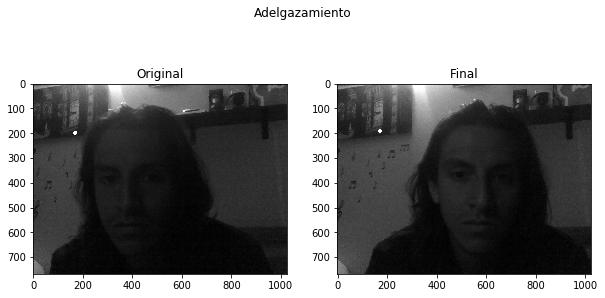

In [10]:


import cv2
img = cv2.imread('Ej/1.jpg',0)
img1 = cv2.imread('Ej/2.jpg',0)
h,w=img.shape[:2]
x=170
y=200
u0,u1=lk(img,img1,x,y,5)
img= cv2.circle(img,(x,y),8,[255,255,255],-1)
img1 = cv2.circle(img1,(int(x+u0),int(y+u1)),8,[255,255,255],-1)
cv2.line(img1, (x, y),( int(x+u0), int(y+u1)), (255, 255, 255),3)

plt.figure(1,figsize=(10,5))
plt.suptitle("Adelgazamiento")
plt.subplot(121), plt.imshow(img, cmap=plt.cm.gray), plt.title('Original')
plt.subplot(122), plt.imshow(img1, cmap=plt.cm.gray), plt.title('Final')
plt.show()

In [15]:
import cv2
cap = cv2.VideoCapture(0)
cap.open(0)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(frame1)
x=100
y=100
while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)    
    #u0,u1=lk(prvs,next,x,y,1)
    prvs=next
    #print (u0,u1)
    #frame2 = cv2.line(frame2, (x,y),(int(x-u0),int(y-u1)), (255,255,255), 5)
    frame2 = cv2.circle(frame2,(x,y),5,(255,255,255),-1)
    #img = cv2.add(frame2,mask)

    
    cv2.imshow('frame',frame2)

    key = cv2.waitKey(5)
    if key == 27:
        cv2.destroyWindow('frame')
        break
cv2.destroyAllWindows()
cap.release() 

In [17]:
img = cv2.imread('Ej/prueba.jpg',0)
print (img)
print (np.gradient(img))

None


ValueError: max() arg is an empty sequence

In [24]:
#!/usr/bin/env python  
  
''''' 
kalman_mousetracker.py - OpenCV mouse-tracking demo using 2D Kalman filter  
 
Adapted from 
 
   http://www.morethantechnical.com/2011/06/17/simple-kalman-filter-for-tracking-using-opencv-2-2-w-code/ 
     
Copyright (C) 2014 Simon D. Levy 
 
This code is free software: you can redistribute it and/or modify 
it under the terms of the GNU Lesser General Public License as 
published by the Free Software Foundation, either version 3 of the 
License, or (at your option) any later version. 
This code is distributed in the hope that it will be useful, 
but WITHOUT ANY WARRANTY without even the implied warranty of 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the 
GNU General Public License for more details. 
 
You should have received a copy of the GNU Lesser General Public License 
along with this code. If not, see <http://www.gnu.org/licenses/>. 
'''  
  
# This delay will affect the Kalman update rate  
DELAY_MSEC = 20  
  
# Arbitrary display params  
WINDOW_NAME = 'Kalman Mousetracker [ESC to quit]'  
WINDOW_SIZE = 500  
  
import cv2  
import numpy as np  
from sys import exit  
  
  
class MouseInfo(object):  
    ''''' 
    A class to store X,Y points 
    '''  
  
    def __init__(self):  
  
        self.x, self.y = -1, -1  
  
    def __str__(self):  
  
        return '%4d %4d' % (self.x, self.y)  
  
def mouseCallback(event, x, y, flags, mouse_info):  
    ''''' 
    Callback to update a MouseInfo object with new X,Y coordinates 
    '''  
  
    mouse_info.x = x  
    mouse_info.y = y  
  
  
def drawCross(img, center, r, g, b):  
    ''''' 
    Draws a cross a the specified X,Y coordinates with color RGB 
    '''  
  
    d = 5  
    t = 2  
  
    color = (r, g, b)  
  
    ctrx = center[0]  
    ctry = center[1]  
  
    cv2.line(img, (ctrx - d, ctry - d), (ctrx + d, ctry + d), color, t, cv2.CV_AA)  
    cv2.line(img, (ctrx + d, ctry - d), (ctrx - d, ctry + d), color, t, cv2.CV_AA)  
  
  
def drawLines(img, points, r, g, b):  
    ''''' 
    Draws lines  
    '''  
  
    cv2.polylines(img, [np.int32(points)], isClosed=False, color=(r, g, b))  
  
  
def newImage():  
    ''''' 
    Returns a new image 
    '''  
  
    return np.zeros((500,500,3), np.uint8)   
  
  
if __name__ == '__main__':  
  
  
    # Create a new image in a named window  
    img = newImage()  
    cv2.namedWindow(WINDOW_NAME)  
  
    # Create an X,Y mouse info object and set the window's mouse callback to modify it  
    mouse_info = MouseInfo()  
    cv2.setMouseCallback(WINDOW_NAME, mouseCallback, mouse_info)  
  
    # Loop until mouse inside window  
    while True:  
  
        if mouse_info.x > 0 and mouse_info.y > 0:  
            break  
  
        cv2.imshow(WINDOW_NAME, img)  
        if cv2.waitKey(1) == 27:  
            exit(0)  
  
  
    # These will get the trajectories for mouse location and Kalman estiamte  
    measured_points = []  
    kalman_points = []  
  
    # Create a new Kalman2D filter and initialize it with starting mouse location  
    kalman2d = Kalman2D()  
  
    # Loop till user hits escape  
    while True:  
  
        # Serve up a fresh image  
        img = newImage()  
  
        # Grab current mouse position and add it to the trajectory  
        measured = (mouse_info.x, mouse_info.y)  
        measured_points.append(measured)  
  
        # Update the Kalman filter with the mouse point  
        kalman2d.update(mouse_info.x, mouse_info.y)  
  
        # Get the current Kalman estimate and add it to the trajectory  
        estimated = [int (c) for c in kalman2d.getEstimate()]  
        kalman_points.append(estimated)  
  
        # Display the trajectories and current points  
        drawLines(img, kalman_points,   0,   255, 0)  
        drawCross(img, estimated,       255, 255, 255)  
        drawLines(img, measured_points, 255, 255, 0)  
        drawCross(img, measured, 0,   0,   255)  
  
        # Delay for specified interval, quitting on ESC  
        cv2.imshow(WINDOW_NAME, img)  
        if cv2.waitKey(DELAY_MSEC) == 27:  
            break  

AttributeError: 'module' object has no attribute 'CreateKalman'

In [22]:
# -*- coding: utf-8 -*-  
''''' 
kalman2d - 2D Kalman filter using OpenCV 
 
Based on http://jayrambhia.wordpress.com/2012/07/26/kalman-filter/ 
 
Copyright (C) 2014 Simon D. Levy 
 
This code is free software: you can redistribute it and/or modify 
it under the terms of the GNU Lesser General Public License as 
published by the Free Software Foundation, either version 3 of the 
License, or (at your option) any later version. 
This code is distributed in the hope that it will be useful, 
 
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the 
GNU General Public License for more details. 
 
You should have received a copy of the GNU Lesser General Public License 
along with this code. If not, see <http://www.gnu.org/licenses/>. 
'''  
  
import cv2  
  
class Kalman2D(object):  
    ''''' 
    A class for 2D Kalman filtering 
    '''  
  
    def __init__(self, processNoiseCovariance=1e-4, measurementNoiseCovariance=1e-1, errorCovariancePost=0.1):  
        ''''' 
        Constructs a new Kalman2D object.   
        For explanation of the error covariances see 
        http://en.wikipedia.org/wiki/Kalman_filter 
        '''  
        # 状态空间：位置--2d,速度--2d  
        self.kalman = cv2.CreateKalman(4, 2, 0)  
        self.kalman_state = cv2.CreateMat(4, 1, cv.CV_32FC1)  
        self.kalman_process_noise = cv2.CreateMat(4, 1, cv.CV_32FC1)  
        self.kalman_measurement = cv2.CreateMat(2, 1, cv.CV_32FC1)  
  
        for j in range(4):  
            for k in range(4):  
                self.kalman.transition_matrix[j,k] = 0  
            self.kalman.transition_matrix[j,j] = 1  
        #加入速度 x = x + vx, y = y + vy  
        # 1,0,1,0,   0,1,0,1,  0,0,1,0,  0,0,0,1  
        #如果把下面两句注释掉，那么位置跟踪kalman滤波器的状态模型就是没有使用速度信息  
#        self.kalman.transition_matrix[0, 2]=1  
#        self.kalman.transition_matrix[1, 3]=1  
          
        cv.SetIdentity(self.kalman.measurement_matrix)  
        #初始化带尺度的单位矩阵  
        cv.SetIdentity(self.kalman.process_noise_cov, cv.RealScalar(processNoiseCovariance))  
        cv.SetIdentity(self.kalman.measurement_noise_cov, cv.RealScalar(measurementNoiseCovariance))  
        cv.SetIdentity(self.kalman.error_cov_post, cv.RealScalar(errorCovariancePost))  
  
        self.predicted = None  
        self.esitmated = None  
  
    def update(self, x, y):  
        ''''' 
        Updates the filter with a new X,Y measurement 
        '''  
  
        self.kalman_measurement[0, 0] = x  
        self.kalman_measurement[1, 0] = y  
  
        self.predicted = cv2.KalmanPredict(self.kalman)  
        self.corrected = cv2.KalmanCorrect(self.kalman, self.kalman_measurement)  
  
    def getEstimate(self):  
        ''''' 
        Returns the current X,Y estimate. 
        '''  
  
        return self.corrected[0,0], self.corrected[1,0]  
  
    def getPrediction(self):  
        ''''' 
        Returns the current X,Y prediction. 
        '''  
  
        return self.predicted[0,0], self.predicted[1,0]  

In [1]:
import cv2, numpy as np

meas=[]
pred=[]
frame = np.zeros((400,400,3), np.uint8) # drawing canvas
mp = np.array((2,1), np.float32) # measurement
tp = np.zeros((2,1), np.float32) # tracked / prediction

def onmouse(k,x,y,s,p):
    global mp,meas
    mp = np.array([[np.float32(x)],[np.float32(y)]])
    meas.append((x,y))

def paint():
    global frame,meas,pred
    for i in range(len(meas)-1): cv2.line(frame,meas[i],meas[i+1],(0,100,0))
    for i in range(len(pred)-1): cv2.line(frame,pred[i],pred[i+1],(0,0,200))

def reset():
    global meas,pred,frame
    meas=[]
    pred=[]
    frame = np.zeros((400,400,3), np.uint8)

cv2.namedWindow("kalman")
cv2.setMouseCallback("kalman",onmouse);
kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.03
kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * 0.00003
while True:
    
    tp = kalman.predict()
    kalman.correct(mp)
    pred.append((int(tp[0]),int(tp[1])))
    paint()
    cv2.imshow("kalman",frame)
    k = cv2.waitKey(30) &0xFF
    if k == 27: break
    if k == 32: reset()

In [3]:
import cv2, numpy as np

cap = cv2.VideoCapture(0)


# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))




# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

meas=[]
pred=[]
#frame = np.zeros((400,400,3), np.uint8) # drawing canvas
mp = np.array((2,1), np.float32) # measurement
tp = np.zeros((2,1), np.float32) # tracked / prediction



def paint():
    global mask,meas,pred
    for i in range(len(meas)-1): cv2.line(mask,meas[i],meas[i+1],(0,100,0))
    for i in range(len(pred)-1): cv2.line(mask,pred[i],pred[i+1],(0,0,200))

def reset():
    global mask,pred,frame
    meas=[]
    pred=[]
    frame = np.zeros((400,400,3), np.uint8)


kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.03
kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * 0.00003



while True:
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if(len(p1)>0):
        good_new = p1[st==1]
        good_old = p0[st==1]
    
        
    
        #print good_new[0].ravel()
        if(len(good_new)>0):
            tp = kalman.predict()
            a,b = good_new[0].ravel()
            meas.append((a,b))
            kalman.correct(np.array([[np.float32(a)],[np.float32(b)]]))
            pred.append((int(tp[0]),int(tp[1])))
            paint()
            frame = cv2.circle(frame,(a,b),5,(255,255,255),-1)
            p0 = good_new.reshape(-1,1,2)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    

cv2.destroyAllWindows()
cap.release()
